In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from IPython.display import display, HTML
import math


## Utils

In [4]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


def k_cross_validation(clf, data, target, get_classifier_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
        
    kf = KFold(n_splits=k, shuffle=True)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)
        mae = get_classifier_mae(clf.predict(X_test), y_test)
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)


    return mae_list, mae_list_train


def show_best_results(results, estimator_name, n=5):
    best_res = sc.sparkContext.parallelize(results).sortBy(lambda x: x['error']).take(n)
    df = pd.DataFrame(list(map(lambda x: x['params'], best_res)))
    df["mean_score_validation"] = list(map(lambda x: x['error'], best_res))
    df["mean_score_training"] = list(map(lambda x: x['error_train'], best_res))
    display(HTML("<h3> {}: top {} combinaciones  </h3>".format(estimator_name, n)))
    display(df.sort_values(by="mean_score_validation", ascending=True).head(n))
    
def regre_grid_search(predictor, params, regre_data, regre_target):
    results = []
    for params in ParameterGrid(params):
        clf = MultiOutputRegressor(predictor(**params))
        res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
def classi_grid_search(predictor, params, classi_data, classi_target):
    results = []
    for params in ParameterGrid(params):
        clf = predictor(**params)
        res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
    
from sklearn.model_selection import GroupKFold



### deprecated
def k_cross_validation_separated_points(clf, data, target, get_classifier_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
    
    unique_target = np.unique(target, axis=0)

    groups = []
    for h in range(len(target)):
        i,j = np.where(unique_target == target[h])
        if i[0] == i[1]:
            groups.append(i[0])
        else:
            raise Exception('Algo anda mal')

    kf = GroupKFold(n_splits=k)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data, groups=groups):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)
        mae = get_classifier_mae(clf.predict(X_test), y_test)
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)


    return mae_list, mae_list_train



## Map utils

In [5]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]

global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [7]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        data_dict['emissions'].append([recep_0[i], recep_1[i], recep_2[i], recep_3[i]])
    return data_dict


In [8]:
points_emisions = points_recep.map(group_emisions)


In [9]:
def expand_rows_with_emissions(row):
    emissions = row.pop('emissions')
    print(row)
    rows = []
    for e in emissions:
        new_row = row.copy()
        new_row['recep'] = e
        rows.append(new_row)
    return rows
        
all_emissions = points_emisions.flatMap(expand_rows_with_emissions)

### Genero los atributos y etiquetas que me interesan

In [10]:
def generate_attrs(row):
    data = {
        'antenna_0': row['recep'][0],
        'antenna_1': row['recep'][1],
        'antenna_2': row['recep'][2],
        'antenna_3': row['recep'][3],
    }
    return {'data': data, 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
all_emissions = all_emissions.map(generate_attrs)

### Saco las emisiones sin ninguna recepcion

In [11]:
all_emissions = all_emissions.filter(lambda x: sum(x['data'].values())>0)

### Normalizo coordenadas

In [12]:
def normalize_coord(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row

all_emissions = all_emissions.map(lambda x: normalize_coord(x))

In [16]:
regre_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())
regre_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())



clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))
#clf = KNeighborsRegressor(n_neighbors=5, weights='distance')



def get_regressor_mae(predictions, real):
    mae = 0
    for i in range(len(predictions)):
        mae += distance(predictions[i], real[i])
    mae = mae/len(predictions)
    return mae


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)

334.4871690910303

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
clf = MultiOutputRegressor(GradientBoostingRegressor())


res_test, res_train = k_cross_validation_separated_points(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)


345.1631696244514

### Clasificacion de puntos

In [18]:
classi_target = pd.DataFrame(all_emissions.map(lambda x: x['point']).collect())
classi_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())


global dict_coordenadas
dict_coordenadas = points_recep.map(lambda x: (x['Punto'],(x['x'], x['y']))).collectAsMap()



def get_classifier_mae(predictions, real):
    sum_error = 0
    count = 0
    for i in range(len(predictions)):
        pred_position = dict_coordenadas[predictions[i]]
        real_position = dict_coordenadas[real[i]]
        sum_error += distance(pred_position, real_position)
        count += 1
    return sum_error/count
    


    

clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
#res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae, 50)
res_test, res_train = k_cross_validation_separated_points(clf, classi_data, classi_target, get_classifier_mae, 50)

np.mean(res_test)

452.2765170629539

## Clasificación de regiones + regresion

In [19]:
def get_region(point):
    x = point['x']
    y = point['y']
    return '{}_{}'.format(x%500, y%500)


def evaluate_classi_regre(classifier, regressor, all_emissions, get_region):
    cr_target = pd.DataFrame(all_emissions.map(get_region).collect())
    cr_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())
    r_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())

    data = np.array(cr_data)
    target = np.array(cr_target).ravel()
    r_target_np = np.array(r_target)


    kf = KFold(n_splits=5, shuffle=True)
    mae_list = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        classifier.fit(X_train, y_train)

        label_list = classifier.predict_proba(X_train)

        regressor.fit(label_list, r_target_np[train_index])

        c_predictions = classifier.predict_proba(X_test)
        r_predictions = regressor.predict(c_predictions)
        mae = get_regressor_mae(r_predictions, r_target_np[test_index])
        mae_list.append(mae)

    print(np.mean(mae_list))
    #print(np.mean(mae_list_train))

evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), all_emissions, get_region) 

335.24119106303294


## Clasificación de regiones + regresion with kd-tree

In [20]:
import kdtree

global tree
tree = kdtree.create(regre_target.drop_duplicates().values.tolist())

def get_region_kd(point):
    max_height = 8
    coordinates = (point['x'], point['y'])
    i = 0
    region = ''
    subtree = tree
    while i < max_height:
        assert subtree.is_balanced
        axis = subtree.axis
        if coordinates[axis] < subtree.data[axis]:
            subtree = subtree.left
            region = region+'0'
        else:
            subtree = subtree.right
            region = region+'1'
        i += 1
    return region


evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), all_emissions, get_region_kd) 
    

336.0066147875867


### Regression grid search

In [17]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}

regre_grid_search(KNeighborsRegressor, knn_params, regre_data, regre_target)
 


,n_neighbors,p,weights,mean_score_validation,mean_score_training
0,20,2,uniform,322.591921,310.170342
1,20,1,uniform,322.613598,309.588816
2,15,2,uniform,322.829253,307.222763
3,15,1,uniform,322.887385,307.061469
4,10,1,uniform,323.006957,304.192710


In [45]:
gboost_params = {
    #"loss" : ["ls", "lad", "huber", "quantile"] ,
    "learning_rate" : np.arange(0.01, 1, 0.1),
    "n_estimators" : np.arange(400, 1000, 200),
    "max_depth": np.arange(2,6),
}

regre_grid_search(GradientBoostingRegressor, gboost_params, regre_data, regre_target)


,learning_rate,max_depth,n_estimators,mean_score_validation,mean_score_training
0,0.01,5,800,619.592210,609.006807
1,0.01,5,600,619.677381,611.127232
2,0.01,4,800,620.277105,614.240005
3,0.01,5,400,620.508881,613.928224
4,0.11,3,400,620.730022,610.203944


In [19]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

regre_grid_search(SVR, {}, regre_data, regre_target)
regre_grid_search(DecisionTreeRegressor, {}, regre_data, regre_target)


/Users/alew/py3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alew/py3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alew/py3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/alew/py3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureW

,mean_score_validation,mean_score_training
0,592.908487,591.64123


,mean_score_validation,mean_score_training
0,337.889653,228.458773


### Classification grid search

In [43]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 4),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}


classi_grid_search(KNeighborsClassifier, knn_params, classi_data, classi_target)

,n_neighbors,p,weights,mean_score_validation,mean_score_training
0,37,2,distance,773.372497,713.456117
1,37,2,uniform,774.314454,758.776850
2,37,1,uniform,778.251208,758.410981
3,37,1,distance,813.958298,754.589553
4,33,1,distance,855.871128,797.329119


### Classi + regre grid search

In [54]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}
try:
    for params_regre in ParameterGrid(knn_params):
        for params_classi in ParameterGrid(knn_params):
            #evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), points) 
            print(params_classi, params_regre)
            evaluate_classi_regre(KNeighborsClassifier(**params_classi), KNeighborsRegressor(**params_regre), all_emissions)
except KeyboardInterrupt:
    print('finished by user')
## El optimo parece estar muy cerca de los parametros default

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
337.85343422930026
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
342.4302061331003
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
finished by user


# Error analysis

### Mapa con ejemplos de predicciones

In [23]:
def show_prediction_map_examples(predictions, real_points):
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    ax = all_points_pos.plot.scatter(x='x', y='y',c='#96EAE1')
    for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")

    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    
    for i in range(len(predictions)):
        predicted_point = predictions[i]
        real_point = real_points[i]

        if all(predicted_point == real_point):
            plt.scatter(predicted_point[0], predicted_point[1], c='g', s=15)
        else:
            
            plt.scatter(predicted_point[0], predicted_point[1], c='r', s=15)
            plt.scatter(real_point[0], real_point[1], c='b', s=15)

            ax.arrow(real_point[0], real_point[1], predicted_point[0]-real_point[0], predicted_point[1]-real_point[1], head_width=30, head_length=30, fc='k', ec='k', length_includes_head=True)
        
        


<IPython.core.display.Javascript object>


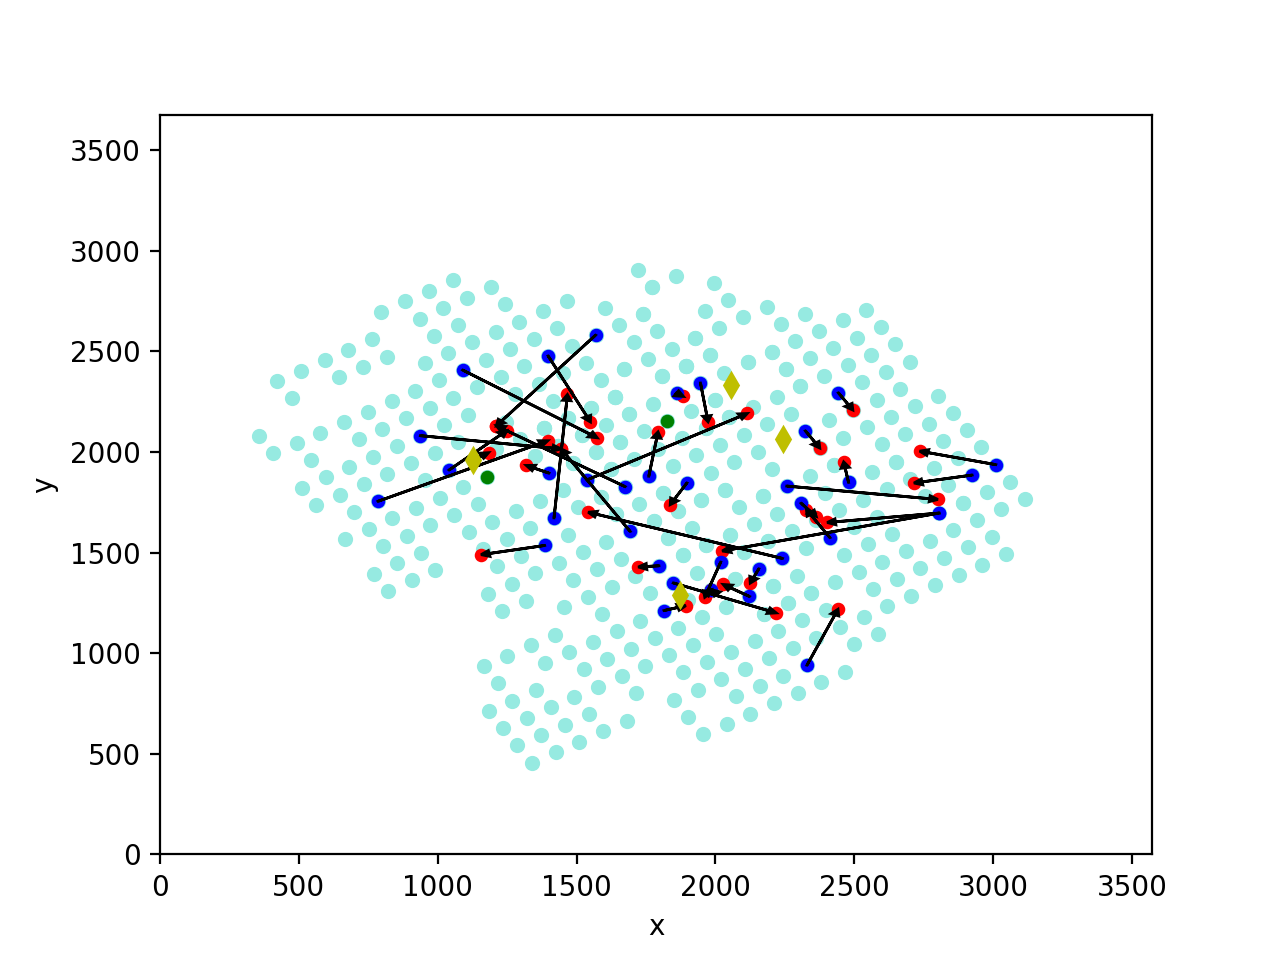

In [58]:
clf = KNeighborsRegressor(n_neighbors=5, weights='distance')
X_train, X_test, y_train, y_test = train_test_split(regre_data, regre_target, test_size=0.007)


clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, np.array(y_test))

### Mapa con ejemplos de predicciones por punto

examining points [265, 361, 305]


<IPython.core.display.Javascript object>


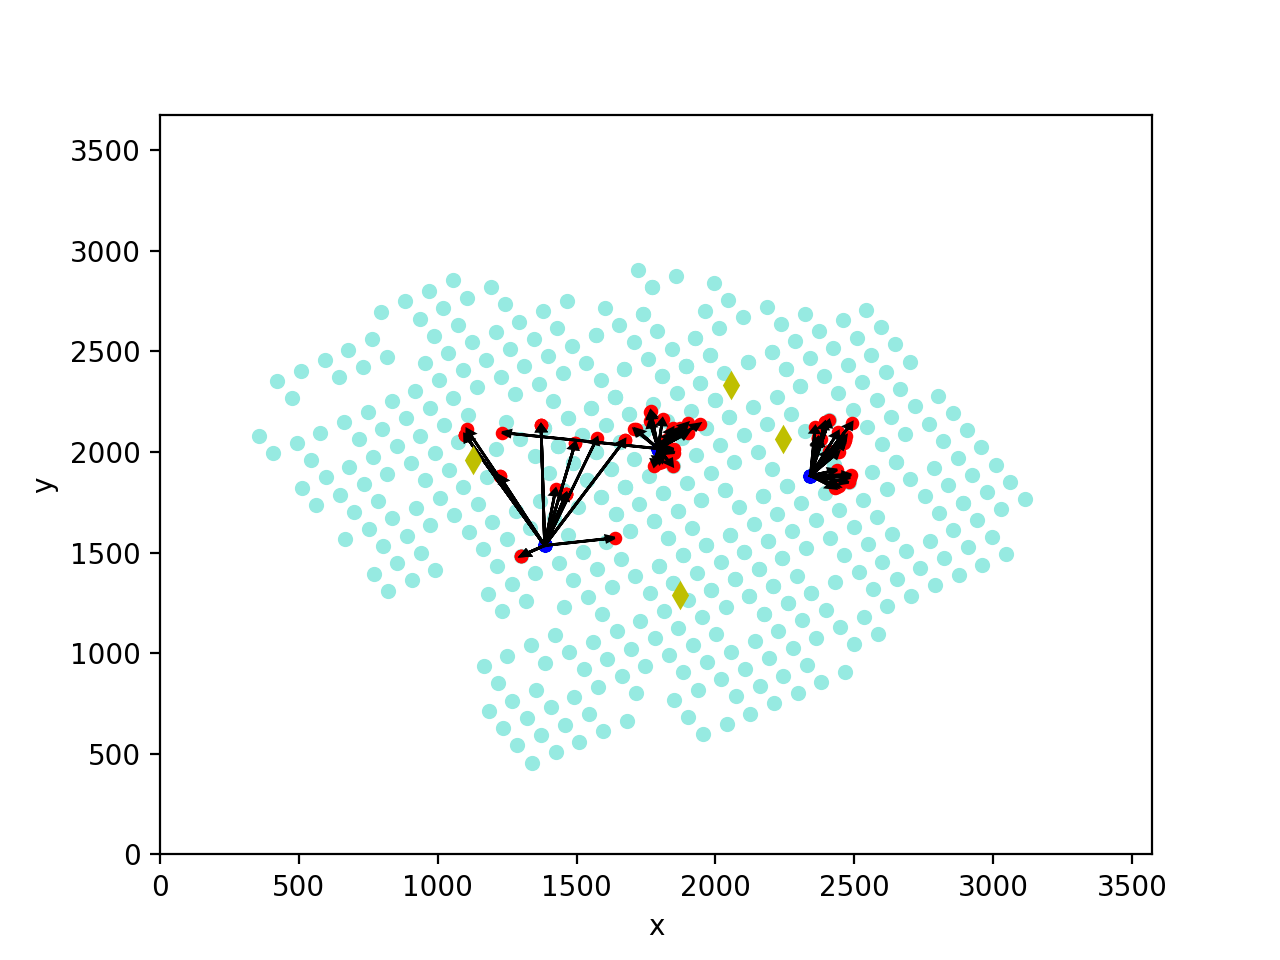

In [64]:
n = 3
sample_points = all_emissions.map(lambda x: x['point']).takeSample(False, n)
print('examining points', sample_points)

X_train = pd.DataFrame(all_emissions.filter(lambda x: x['point'] not in sample_points).map(lambda x: x['data']).collect())
y_train = pd.DataFrame(all_emissions.filter(lambda x: x['point'] not in sample_points).map(lambda x: [x['x'], x['y']]).collect())

X_test = pd.DataFrame(all_emissions.filter(lambda x: x['point'] in sample_points).map(lambda x: x['data']).collect())
y_test = pd.DataFrame(all_emissions.filter(lambda x: x['point'] in sample_points).map(lambda x: [x['x'], x['y']]).collect())




clf = KNeighborsRegressor(n_neighbors=5, weights='distance')

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, np.array(y_test))